# 0. Эксперименты с bigCLAM, weightedBigCLAM и gammaModel

Основные цели: 

* Проверить как ведет себя логарифм правдоподобия трех моделей
* Проверить адекватность поведения моделей в зависимости от начальных приближений
* Убедиться в отсутствии ошибок в коде

Везде, где можно, будем смотреть на поведение моделей при разных значениях количества сообществ (истинное количество и одно дополнительное). Местами будут выводы.

Подбор Membership пока тупой и местами может работать хуже, чем мог бы

In [2]:
import numpy as np
import scipy as sp
import scipy.spatial as spatial
import matplotlib.pyplot as plt
import networkx as nx
import cPickle
from Extends import toBigClamFormat, fromBigClamFormat
import subprocess
import os
from big_clam import BigClam
from big_clam_gamma import BigClamGamma

%matplotlib inline 

In [3]:
from Experiments import *

# 3. Пример с 3 пересекающимися сообществами

Для генерации матрицы смежности используется модель *gamma_model_test_data* с зашитым гамма распределением.
Т.к. должно быть все равно какое распределение имеют веса внутри сообществ.

Основной тест приведен ниже. Если все будет плохо тест будет упрощаться.

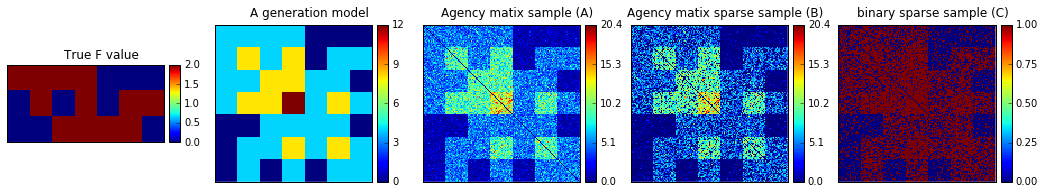

In [4]:
F_true = Fs3[0]
A = gamma_model_test_data(F_true)
power = 0.2
P = 1 - np.exp(- power * A)
mask = P <= np.random.rand(*A.shape)

B = A.copy()
B[mask] = 0
C = B.copy()
C[B != 0] = 1

draw_test_sample(F_true, A, B, C)

## 3.1 BigCLAM (взвешенный вариант)

Основная матрица смежности для работы — B

In [5]:
eps = 1e-4

w_model = BigClam(B, 3, debug_output=False, LLH_output=True, eps=eps)
F_model, LLH = w_model.fit()

w_model7 = BigClam(B, 7, debug_output=False, LLH_output=True, eps=eps)
F_model7, LLH7 = w_model7.fit()

iter: 140, LLH:-41205.4227937
iter: 280, LLH:-37025.5232025
iter: 420, LLH:-28546.7140363
iter: 560, LLH:-28664.8306097
iter: 700, LLH:-28222.6200517
iter: 840, LLH:-27992.6322691
iter: 980, LLH:-27616.4932107
iter: 1120, LLH:-27539.1866902
iter: 1260, LLH:-27419.9771525
iter: 1400, LLH:-27394.9382891
iter: 1540, LLH:-27351.1284692
iter: 1680, LLH:-27366.0609755
iter: 1820, LLH:-27339.7433818
iter: 1960, LLH:-27355.2483279
iter: 2100, LLH:-27346.0570021
iter: 2240, LLH:-27350.7113927
iter: 140, LLH:-34071.282626
iter: 280, LLH:-32353.864228
iter: 420, LLH:-28056.4981395
iter: 560, LLH:-28100.9370172
iter: 700, LLH:-27651.6072235
iter: 840, LLH:-27531.8644142
iter: 980, LLH:-27352.2080671
iter: 1120, LLH:-27378.4024845
iter: 1260, LLH:-27276.0764748
iter: 1400, LLH:-27298.4044321
iter: 1540, LLH:-27258.2706156


In [6]:
print "True LLH:  {:.2f}\n3 comm LLH:{:.2f}\n7 comm LLH:{:.2f}".format(w_model.loglikelihood(F_true.T), LLH, LLH7)

True LLH:  -38788.04
3 comm LLH:-27339.74
7 comm LLH:-27258.27


Наблюдаем, что у истинного F значение правдоподобия намного выше, что не удивительно, ведь модель генерации отличается от модели, которую использует BigClam.
Еще интересно, что при 3 и 7 сообществах значения правдоподобия очень похожи (см. подбор количества сообществ)

**TODO:** Проверить степень правдоподобия, которая достигается на различных значениях *power* 

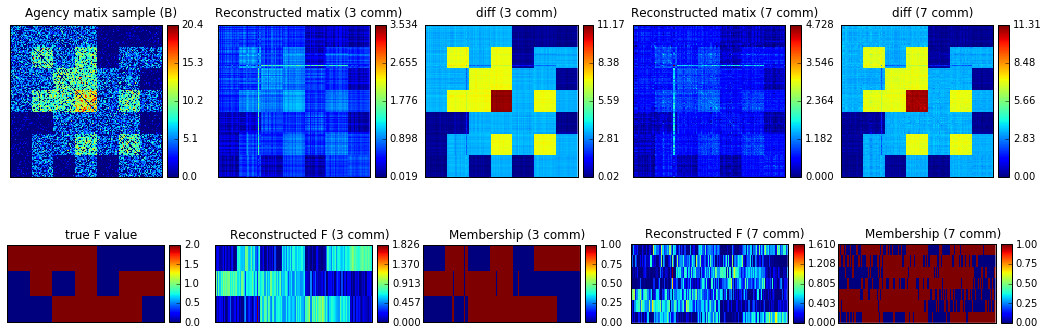

In [7]:
draw_res(B, F_true, F_model, F_model7)

** Интересное наблюдение: ** Если пытаемся восстановить больше сообществ, чем есть (6 график), то получаем сильно коррелированные сообщества. Возможно, так можно подбирать их количество.

## 3.2 BigCLAM (оригинальный вариант)

### Тестирование на не правильной гамма модели

Модель является не правильной, т.к. bigClAM оптимизирует не ее. Значит не стоит расчитывать на восстановление матрицы *F*. Однако, структура сообществ все равно может быть восстановлена, что и будет продемонстрированно.

Рассмотрим несколько вариантов инициализации.

#### Близкая к оптимуму инициализация

Используем только 3 сообщества, т.к. только для этого случая можем взять истинное значение и зашумить его:

In [8]:
noise_forse = 0.2
noise = -noise_forse + 2 * noise_forse * np.random.rand(*F_true.T.shape)
init =  1.0 * F_true.T + noise
init[init < 0] = 0

w_model2 = BigClam(C, 3, debug_output=False, LLH_output=False, initF=init, iter_output=1)
F_model2, LLH2 = w_model2.fit()


big_clam.py:319: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  F = self.initRandF() if self.initFmode == 'rand' else self.initNeighborComF() if self.initFmode is None else \
big_clam.py:320: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  self.initZeros() if self.initFmode == 'zeros' else self.initFromSpecified()


2519


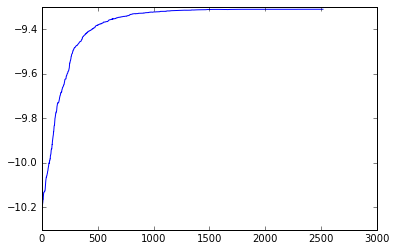

In [9]:
print len(w_model2.LLH_output_vals)
plt.plot(-np.log(-np.array(w_model2.LLH_output_vals[:3000])))

Типичная картина для правдоподобия.

In [10]:
print "True LLH:  {:.2f}, {:.2f}\n3 comm LLH:{:.2f}, {:.2f}".format(w_model2.loglikelihood(F_true.T), 
                                                                                           np.log(-w_model2.loglikelihood(F_true.T)), 
                                                                                           LLH2, np.log(-LLH2))

True LLH:  -33139.66, 10.41
3 comm LLH:-11069.68, 9.31


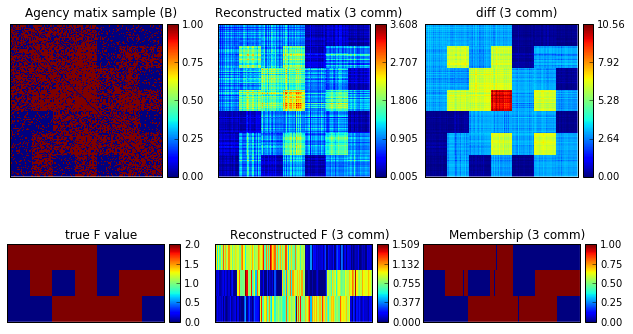

In [11]:
draw_res(C, F_true, F_model2)

#### Вывод

* Матрица А восстанавливается плохо, но это естественно, поскольку модель, которую оптимизирует BigCLAM, не совпадает с моделью генерации.
* Сама структура сообществ восстановлена достаточно хорошо.

#### Случайная инициализация

In [12]:
w_model2r = BigClam(C, 3, debug_output=False, LLH_output=False, initF='rand', iter_output=1)
F_model2r, LLH2r = w_model2r.fit()

w_model72r = BigClam(C, 7, debug_output=False, LLH_output=False, initF='rand', iter_output=1)
F_model72r, LLH72r = w_model72r.fit()

In [13]:
print "True LLH:  {:.2f}, {:.2f}\n3 comm LLH:{:.2f}, {:.2f}\n7 comm LLH:{:.2f}, {:.2f}".format(w_model2r.loglikelihood(F_true.T), 
                                                                                               np.log(-w_model2r.loglikelihood(F_true.T)), 
                                                                                               LLH2r, np.log(-LLH2r), LLH72r, np.log(-LLH72r))

True LLH:  -33139.66, 10.41
3 comm LLH:-11125.63, 9.32
7 comm LLH:-10889.97, 9.30


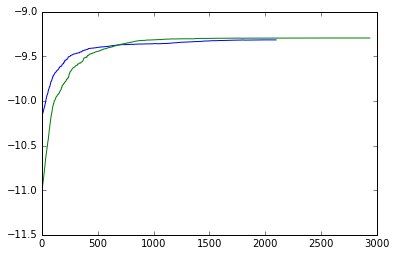

In [14]:
plt.plot(-np.log(-np.array(w_model2r.LLH_output_vals[:3000])), 'b-')
plt.plot(-np.log(-np.array(w_model72r.LLH_output_vals[:3000])), 'g-')

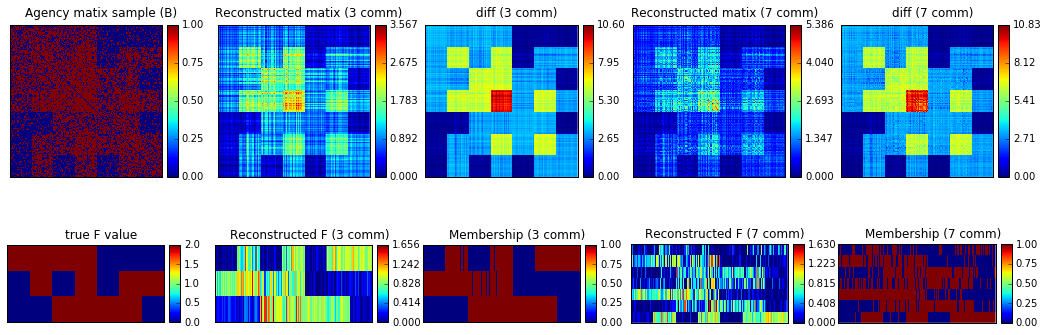

In [15]:
draw_res(C, F_true, F_model2r, F_model72r)

В данном случае, при менее плотной матрице, чем в следующем ниже примере, восстановление происходит достаточно точно. 
Вот пример, когда матрица смежности очень плотная, а восстановление происходит хуже.

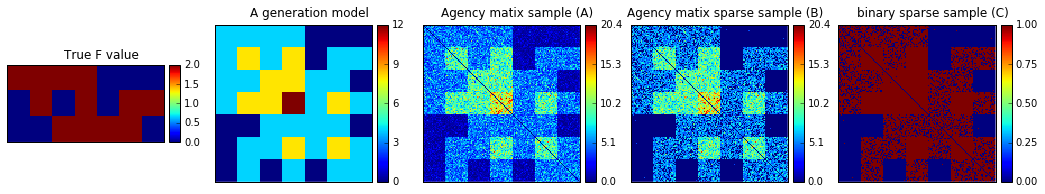

In [18]:
x = np.mean(A) * 0.8
B_bad = A.copy()
B_bad[B_bad < x] = 0
C_bad = B_bad.copy()
C_bad[C_bad >=x] = 1

draw_test_sample(F_true, A, B_bad, C_bad, x)

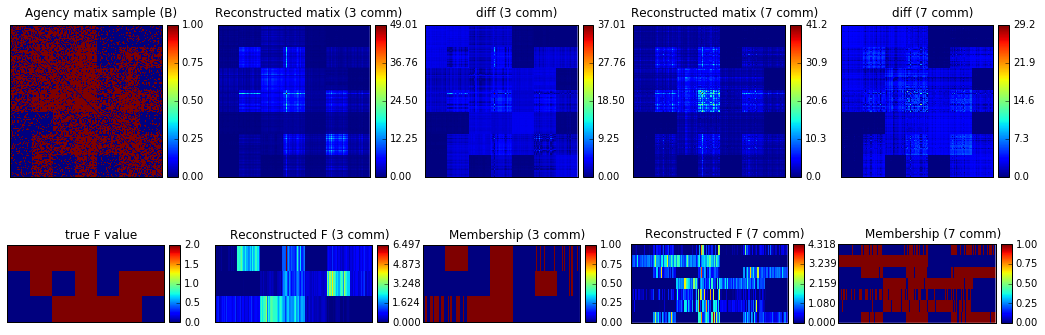

In [20]:
w_model2r_bad = BigClam(C_bad, 3, debug_output=False, LLH_output=False, initF='rand', iter_output=1)
F_model2r_bad, LLH2r_bad = w_model2r_bad.fit()

w_model72r_bad = BigClam(C_bad, 7, debug_output=False, LLH_output=False, initF='rand', iter_output=1)
F_model72r_bad, LLH72r_bad = w_model72r_bad.fit()

draw_res(C, F_true, F_model2r_bad, F_model72r_bad)

### Общий вывод
Оригинальный BigClam чувствителен к начальному приближению, а значит менее устойчив по сравнению с другими методами.
Не всегда это видно на графиках (зависит от *power*), но восстановление происходит не всегда корректно.

### Правильная модель данных для BigCLAM

Рассмотрим более простой пример для оригинального алгоритма

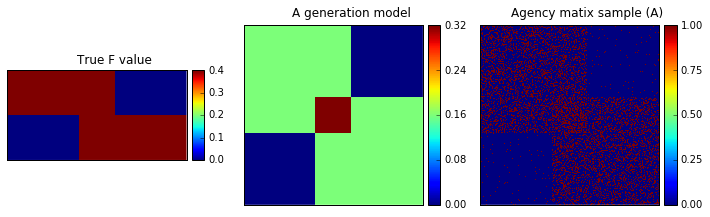

In [39]:
F_true_bc = 0.2 * Fs2[-1]
B_bc = big_clam_model_test_data(F_true_bc)
draw_test_sample(F_true_bc, B_bc)

### Случайная инициализация

In [40]:
w_model2_bc = BigClam(B_bc, 2, debug_output=False, LLH_output=False, initF='rand', iter_output=1)
F_model2_bc, LLH2_bc = w_model2_bc.fit()

w_model72_bc = BigClam(B_bc, 3, debug_output=False, LLH_output=False, initF='rand', iter_output=1)
F_model72_bc, LLH72_bc = w_model72_bc.fit()

2199


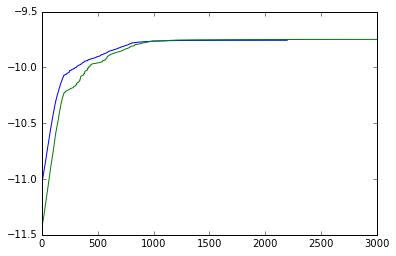

In [41]:
print len(w_model2_bc.LLH_output_vals)
plt.plot(-np.log(-np.array(w_model2_bc.LLH_output_vals[:3000])))
plt.plot(-np.log(-np.array(w_model72_bc.LLH_output_vals[:3000])))

Наблюдаем более адекватное поведедение правдоподобия

In [42]:
print "True LLH:  {:.2f}, {:.2f}\n3 comm LLH:{:.2f}, {:.2f}\n7 comm LLH:{:.2f}, {:.2f}".format(w_model2_bc.loglikelihood(F_true_bc.T), 
                                                                                               np.log(-w_model2_bc.loglikelihood(F_true_bc.T)), 
                                                                                               LLH2_bc, np.log(-LLH2_bc), LLH72_bc, np.log(-LLH72_bc))

True LLH:  -21424.18, 9.97
3 comm LLH:-17273.87, 9.76
7 comm LLH:-17134.70, 9.75


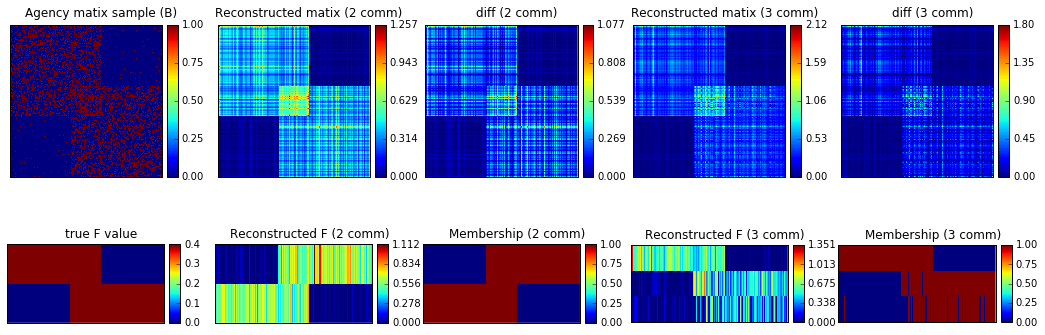

In [44]:
draw_res(B_bc, F_true_bc, F_model2_bc, F_model72_bc)

### Странное начальное приближение — странный результат

iter: 140, LLH:-43994.075815
iter: 280, LLH:-16836.604489
iter: 420, LLH:-13413.2558617
iter: 560, LLH:-12576.0467625
iter: 700, LLH:-12157.0469753
iter: 840, LLH:-11962.917655
iter: 980, LLH:-11670.249669
iter: 1120, LLH:-11366.4018181
iter: 1260, LLH:-11222.2805917
iter: 1400, LLH:-11167.3311044
iter: 1540, LLH:-11144.725656
iter: 1680, LLH:-11132.2241887
iter: 1820, LLH:-11131.0655272
iter: 1960, LLH:-11126.128426
iter: 2100, LLH:-11128.3051916
iter: 2240, LLH:-11125.1000498


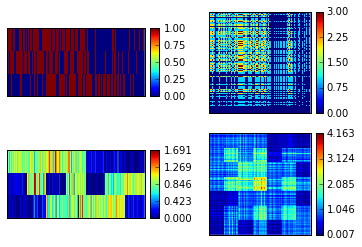

In [45]:
w_model2t = BigClam(C, 3, debug_output=False, LLH_output=True)
F_model2t, LLH2t = w_model2t.fit()
plt.figure()
plt.subplot(221)
draw_matrix(w_model2t.initFmode.T)
plt.subplot(222)
draw_matrix(w_model2t.initFmode.dot(w_model2t.initFmode.T))
plt.subplot(223)
draw_matrix(F_model2t.T)
plt.subplot(224)
draw_matrix(F_model2t.dot(F_model2t.T))

Такое приближение выдал мой алгоритм на этом примере. Из него тоже ничего не сходится.

**TODO:** Посмотреть, что за приближение такое странное, так ли происходит в оригрнале.

## 3.3 Гамма модель

### Случайная инициализация

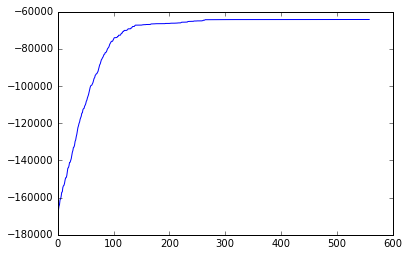

In [49]:
    w_model3r = BigClamGamma(B, 3, debug_output=False, LLH_output=False, initF='rand', iter_output=1)
    F_model3r, LLH3r = w_model3r.fit()
    
    plt.plot(w_model3r.LLH_output_vals)
    w_model73r = BigClamGamma(B, 7, debug_output=False, LLH_output=False, initF='rand', iter_output=1)
    F_model73r, LLH73r = w_model73r.fit()

559


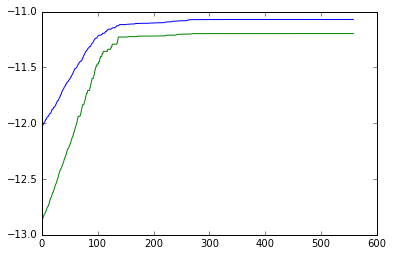

In [50]:
# print len(w_model3r.LLH_output_vals)
plt.plot(-np.log(-np.array(w_model3r.LLH_output_vals[:3000])))

print len(w_model73r.LLH_output_vals)
plt.plot(-np.log(-np.array(w_model73r.LLH_output_vals[:3000])))

In [51]:
print "True LLH:  {:.2f}\n3 comm LLH:{:.2f}\n7 comm LLH:{:.2f}".format(w_model3r.loglikelihood(F_true.T), LLH3r, LLH73r)

True LLH:  -149017.76
3 comm LLH:-64241.04
7 comm LLH:-72900.44


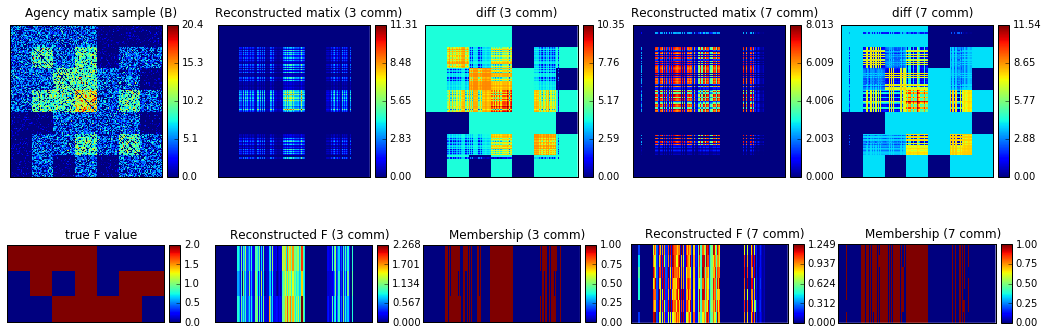

In [52]:
draw_res(B, F_true, F_model3r, F_model73r)

**Вывод:** Для случайного начального приближения ничего не работает.

### Инициализация правильным значением

In [53]:
    w_model3 = BigClamGamma(A, 3, debug_output=False, LLH_output=False, initF=1.0 * F_true.T, iter_output=1)
    F_model3, LLH3 = w_model3.fit()

0


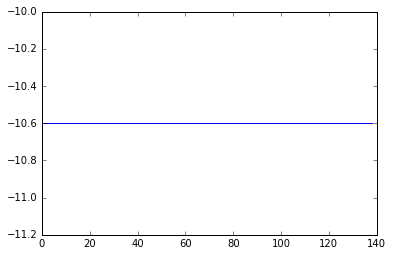

In [54]:
# print len(w_model3.LLH_output_vals)
plt.plot(-np.log(-np.array(w_model3.LLH_output_vals[:3000])))

print len(w_model3.hist[3])

Все шаги были нулевыми

In [55]:
print "True LLH:  {:.2f}\n3 comm LLH:{:.2f}".format(w_model3.loglikelihood(F_true.T), LLH3)

True LLH:  -40118.76
3 comm LLH:-40118.76


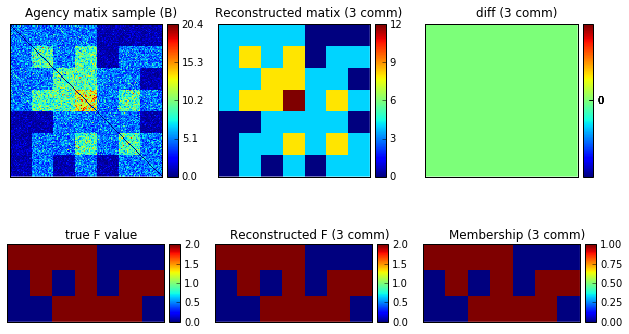

In [56]:
draw_res(A, F_true, F_model3)

**Вывод:** Оптимизационная схема работает правильно

### Инициализация правильным значением с отклонением

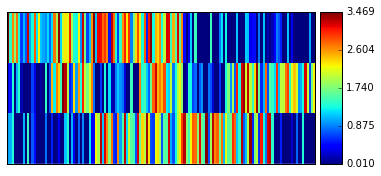

In [72]:
noise_forse = 1.5
noise = -noise_forse + 2 * noise_forse * np.random.rand(*F_true.T.shape)
init =  1.0 * F_true.T + noise
init[init<0.01] = 0.01    
draw_matrix(init.T)

In [73]:
w_model3 = BigClamGamma(A, 3, debug_output=False, LLH_output=False, initF=init, iter_output=1)
F_model3, LLH3 = w_model3.fit()

419
116


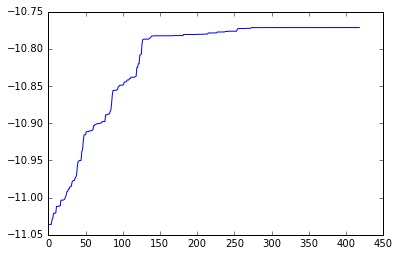

In [74]:
print len(w_model3.LLH_output_vals)
plt.plot(-np.log(-np.array(w_model3.LLH_output_vals[:3000])))

print len(w_model3.hist[3])

In [75]:
print "True LLH:  {:.2f}\n3 comm LLH:{:.2f}".format(w_model3.loglikelihood(F_true.T), LLH3)

True LLH:  -40118.76
3 comm LLH:-47640.83


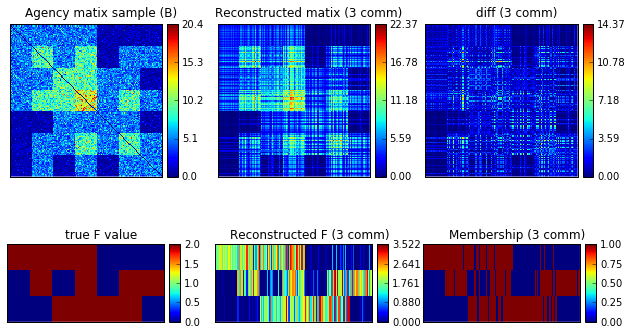

In [76]:
draw_res(A, F_true, F_model3)

### Общий вывод

* Отличное восстановление из хорошего приближения
* Необходимо придумать хорошее приближение
* Если шум = 2, матрица восстанавливается хуже. Шум = 1.5 еще более менее

# 4. Подбор количества сообществ

Было замечено, что при увеличении числа сообществ, логарифм правдоподобия не сильно возрастает после того, как пройдено истинное число сообществ. Проверим этот факт.

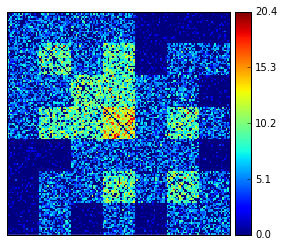

In [99]:
draw_matrix(B)
eps = 1e-2
comm_count = range(1, 10)
init = None
Fs = []
LLHs = []
for i in comm_count:
    bc = BigClam(B, i, initF='rand', debug_output=False, LLH_output=False, eps=eps)
    res = bc.fit()
    Fs.append(res[0])
    LLHs.append(res[1])

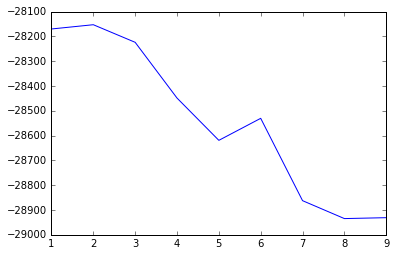

In [98]:
#print '\n'.join("LLH{0}:".format(x)+" {:.2f}" for x in comm_count).format(*LLHs)
plt.plot(comm_count, LLHs)


На модельных данных факт не сильно заметен, хотя прослеживается. Максимум достигается на двух сообществах, хотя на самом деле их 3.

### Проверка на реальных данных

In [100]:
s = 0
import os
DATA_PATH = '../data/vk/'
ego_paths = [f for f in os.listdir(DATA_PATH) if f.endswith(".ego")]
Fss = []
LLHs = []
comm = range(1, 15)
for ego in ego_paths:
    D = cPickle.load(file('../data/vk/{}'.format(ego)))
    G = nx.Graph(D)
    A = np.array(nx.to_numpy_matrix(G))
    Fs = []
    LLH = []
    for k in comm:
        bigClam = BigClam(A, k, sparsity_coef=s, LLH_output=False, eps = 1e-2)
        res = bigClam.fit(A, k)
        Fs.append(res[0])
        LLH.append(res[1])
        print ".",
    Fss.append(Fs)
    LLHs.append(LLH)
    print "."

. . . . . . . . . . . . . . .
. . . . . . . . . . . . . . .
. . . . . . . . . . . . . . .
. . . . . . . . . . . . . . .


Ниже продемонстрирован просто способ подбора количества сообществ. Если прирост опускается ниже чем 0.05 от первоначального, то считается, что оптимум по количесву сообществ достигнут. Приведен пример для 4 реальных графов. 

** TODO: ** Проверить как будет работать блочная L1 регуляризация.

4 2 4 3


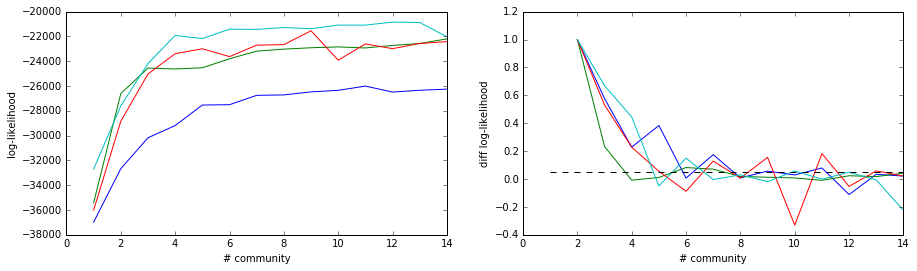

In [104]:
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(comm, np.array(LLHs).T)
plt.xlabel("# community")
plt.ylabel("log-likelihood")
plt.subplot(122)

dLLHs = np.diff(np.array(LLHs)).T
dLLHs = dLLHs / dLLHs[0,:]
for dLLH in dLLHs.T:
    plt.plot(comm[1:], dLLH)  
plt.xlabel("# community")
plt.ylabel("diff log-likelihood")
bord = 0.05
plt.plot([min(comm), max(comm)],[bord, bord], 'k--')
for dLLH in dLLHs.T:
    print np.nonzero(dLLH < bord)[0][0],
  

Так же вопрос можно изучить со стороны степени коррелированности матрицы F, что было замечено на многочисленных примерах.

In [105]:
def calc_corr(F):
    #print 
    X = np.sum(F, axis=1)
    Fn = F[X!=0,:] * (1 / X[X!=0,None])
    pen = Fn.T.dot(Fn)
    #print pen.shape
    np.fill_diagonal(pen, 0)
    pen = np.sum(pen) / F.shape[1]
    return pen

def calc_dist(F):
    X = spatial.distance.pdist(F.T, metric='cosine')
    return sum(X) / X.shape[0] if X.shape[0] != 0 else 0

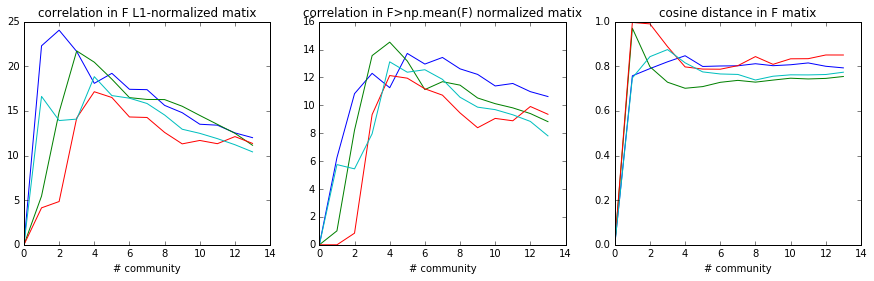

In [106]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.plot(np.array([[calc_corr(F) for F in Fs] for Fs in Fss]).T)
plt.xlabel("# community")
plt.title("correlation in F L1-normalized matix")
plt.subplot(132)
plt.plot(np.array([[calc_corr(1.0*(F>np.mean(F))) for F in Fs] for Fs in Fss]).T)
plt.xlabel("# community")
plt.title("correlation in F>np.mean(F) normalized matix")
plt.subplot(133)
plt.plot(np.array([[calc_dist(F) for F in Fs] for Fs in Fss]).T)
plt.xlabel("# community")
plt.title("cosine distance in F matix")

### Выводы
* Метод сломанной трости применим к задаче.
* Интересное поведение у степени коррелированности матрицы F -- с ростом количества сообществ оно падает, что противоречит предположению. (Выводы?)

**TODO:** Проверить на каких-нибудь бенчмарках.

# 5. Зависимость качества оптимизации от размера сообщества

**Задача:** Потестировать качество работы алгоритма в зависимости от размеров модельного графа (кол-ва вершин в каждом сообществе)

In [10]:
def simple_test(size=20, overlapping=10):
    return np.array([[1.0] * size + [0.0] * (size - overlapping), [0.0] * (size-overlapping) + [1.0] * size])

In [29]:
s = 0
LLHs = []
Fss = []
LLHs_true = []
sizes = [5,6,7,8,9, 10,12,14,16,18, 20,30, 40,50,60,70, 100, 150]
overlappings = [0, 0.05, 0.1, 0.2, 0.5, 0.75]
for size in sizes:
    LLH = []
    LLH_true = []
    Fs = []
    for overlapping in overlappings:
        F = 0.5 * simple_test(size, np.floor(overlapping*size))
        A = big_clam_model_test_data(F)
        #draw_test_sample(F, A)
        bigClam = BigClam(A, 2, sparsity_coef=s, LLH_output=False)
        res = bigClam.fit()
        Fs.append(res[0])
        LLH.append(res[1])
        LLH_true.append(bigClam.loglikelihood(F.T))
        print ".",
    Fss.append(Fs)
    LLHs.append(LLH)
    LLHs_true.append(LLH_true)
    print "."

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .


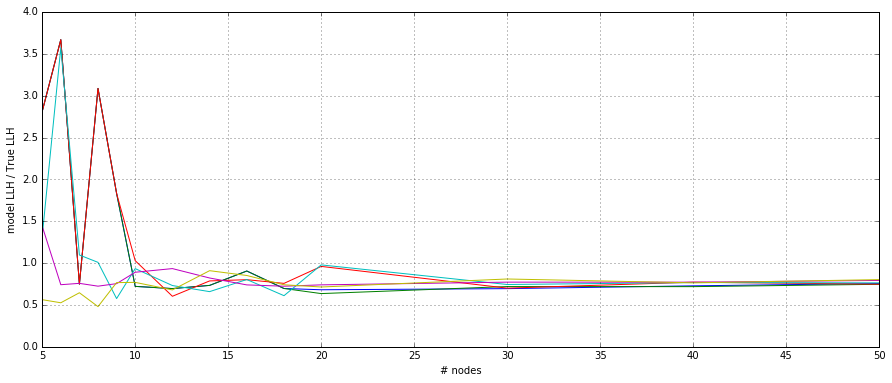

In [40]:
plt.figure(figsize=(15,6))
plt.plot(sizes, np.array(LLHs) / np.array(LLHs_true), label=["0", "0.05", "0.1", "0.2", "0.5", "0.75"])
plt.xlim([5,50])
plt.grid()
plt.xlabel("# nodes")
plt.ylabel("model LLH / True LLH")

Видно, что до некоророго момента (<10 вершин) модель переобучается.
После 10 выходит на некоторый постоянный уровень провдоподобия (75-80% от истинного)

# 6. Регуляризация для декорреляции матрицы F

**Проблема:** Часто метод выдает сообщества, которые имеют значительные пересечения между собой. Хочется избавится от этой особенности. Для избавления будем добавлять следующий регуляризатор:

$$
Pen = -\alpha \sum_{i\ne j}F_i^T F_j.
$$

Протестируем поведение коррелированности в зависимости от коэффициента $ \alpha $. Построим график зависимости $ Pen/\alpha $ от $\alpha$.
Проведем эксперимент на реальных данных для трех случаев: малого числа сообществ (2), оптимального (4), и большого (8)

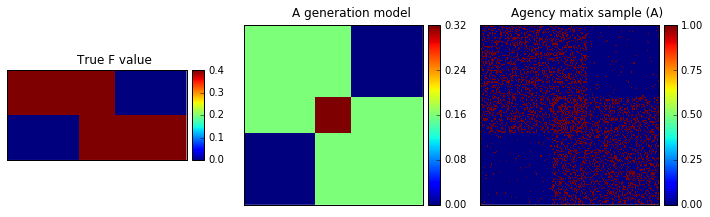

In [70]:
test_size = 8
F_true_bc = 0.4 * np.array([[1] * 12 * test_size + [0] * 8 * test_size, [0] * 8 * test_size + [1] * 12 * test_size])
B_bc = big_clam_model_test_data(F_true_bc)
draw_test_sample(F_true_bc, B_bc)

In [85]:
K = 3
sparsity_coefs = np.linspace(1, 500, 100)
init = None

Fs = []
pen = []
for s in log_progress(sparsity_coefs):
    bigClam = BigClam(B_bc, K, sparsity_coef=s, initF='rand' if init is None else init, debug_output=False, LLH_output=False, eps=1e-4, alpha=0.1)
    Fs.append(bigClam.fit())
    pen.append(bigClam.calc_penalty(Fs[-1][0], real=True))
    if init is None:
        init = bigClam.initFmode.copy()

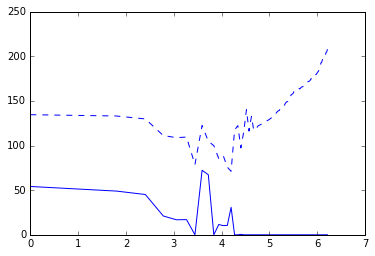

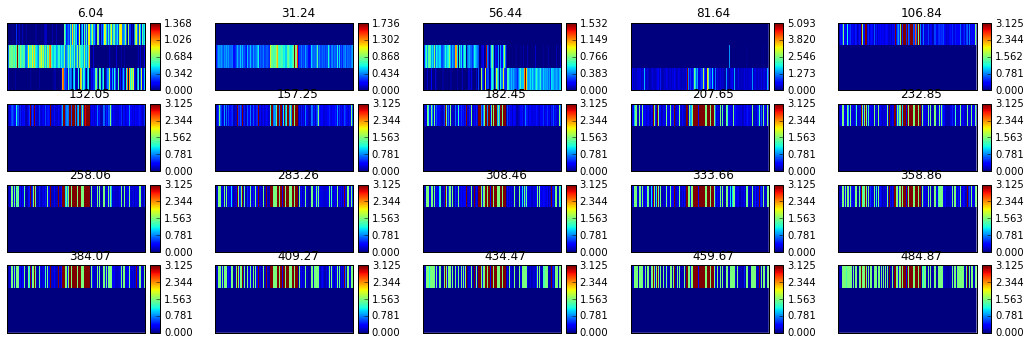

In [86]:
plt.plot(np.log(0.000001 + np.array(sparsity_coefs)), np.array(pen), 'b')
plt.plot(np.log(0.000001 + np.array(sparsity_coefs)), np.array([np.sum(np.abs(F[0])) for F in Fs]), 'b--')
plt.figure(figsize=(18, 7))
for j in xrange(1, 100, 5):
    plt.subplot(5, 5, np.floor(j / 5) + j % 5)
    draw_matrix(Fs[j][0].T, np.floor(100* sparsity_coefs[j]) / 100)

Первое, что бросается в глаза -- неустойчивое поведение правдоподобия. Там, где значение достигает нуля, обычно матрица F просто нулевая (локальный минимум). Возможно, это можно поправить, если отделяться от нуля небольшим значением. Без этого видим, что оптимизационная процедура сваливаеся в 0.

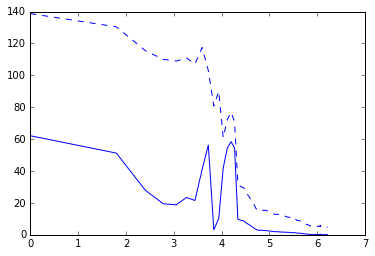

In [87]:
K = 3
sparsity_coefs = np.linspace(1, 500, 100)
init = None

Fs = []
pen = []
for s in log_progress(sparsity_coefs):
    bigClam = BigClam(B_bc, K, sparsity_coef=s, initF='rand' if init is None else init, debug_output=False, LLH_output=False, eps=1e-4, alpha=0.1, zero_eps=0.01)
    Fs.append(bigClam.fit())
    pen.append(bigClam.calc_penalty(Fs[-1][0], real=True))
    if init is None:
        init = bigClam.initFmode.copy()

plt.plot(np.log(0.000001 + np.array(sparsity_coefs)), np.array(pen), 'b')
plt.plot(np.log(0.000001 + np.array(sparsity_coefs)), np.array([np.sum(np.abs(F[0])) for F in Fs]), 'b--')

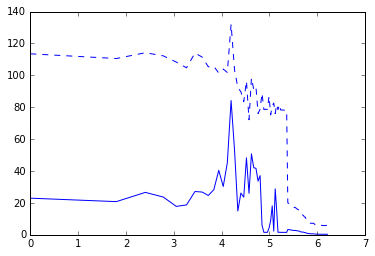

In [88]:
K = 2
sparsity_coefs = np.linspace(1, 500, 100)
init = None

Fs = []
pen = []
for s in log_progress(sparsity_coefs):
    bigClam = BigClam(B_bc, K, sparsity_coef=s, initF='rand' if init is None else init, debug_output=False, LLH_output=False, eps=1e-4, alpha=0.1, zero_eps=0.01)
    Fs.append(bigClam.fit())
    pen.append(bigClam.calc_penalty(Fs[-1][0], real=True))
    if init is None:
        init = bigClam.initFmode.copy()

plt.plot(np.log(0.000001 + np.array(sparsity_coefs)), np.array(pen), 'b')
plt.plot(np.log(0.000001 + np.array(sparsity_coefs)), np.array([np.sum(np.abs(F[0])) for F in Fs]), 'b--')

In [89]:
    K = 4
    import os
    DATA_PATH = '../data/vk/'
    ego_paths = [f for f in os.listdir(DATA_PATH) if f.endswith(".ego")]
    Fss = []
    pens = []
    #sparsity_coefs = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]
    sparsity_coefs = [0.001, 0.01, 0.1, 1, 10, 100, 200]
    for ego in ego_paths:
        D = cPickle.load(file('../data/vk/{}'.format(ego)))
        G = nx.Graph(D)
        A = np.array(nx.to_numpy_matrix(G))
        Fs = []
        pen = []
        init = None
        for s in log_progress(sparsity_coefs):
            bigClam = BigClam(A, K, sparsity_coef=s, initF='rand', debug_output=False, LLH_output=False)
            Fs.append(bigClam.fit())
            pen.append(bigClam.calc_penalty(Fs[-1][0], real=True))
            if init is None:
                init = bigClam.initFmode.copy()
        Fss.append(Fs)
        pens.append(pen)

Рассмотрим аналогичный пример на реальных данных, посмотрим на матрицу F в зависимости от коэффициента:

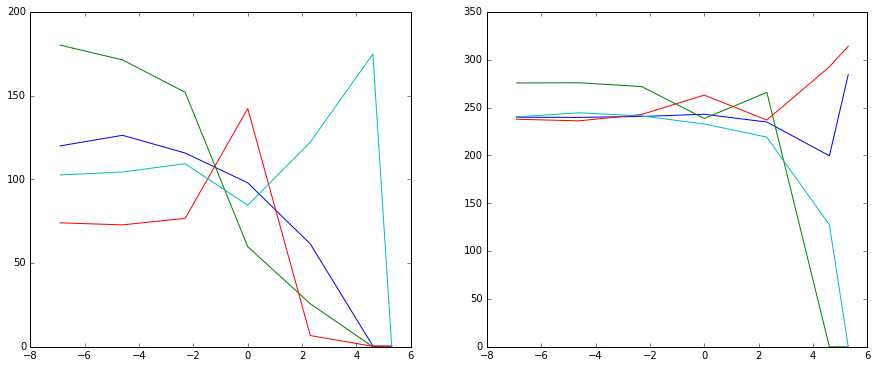

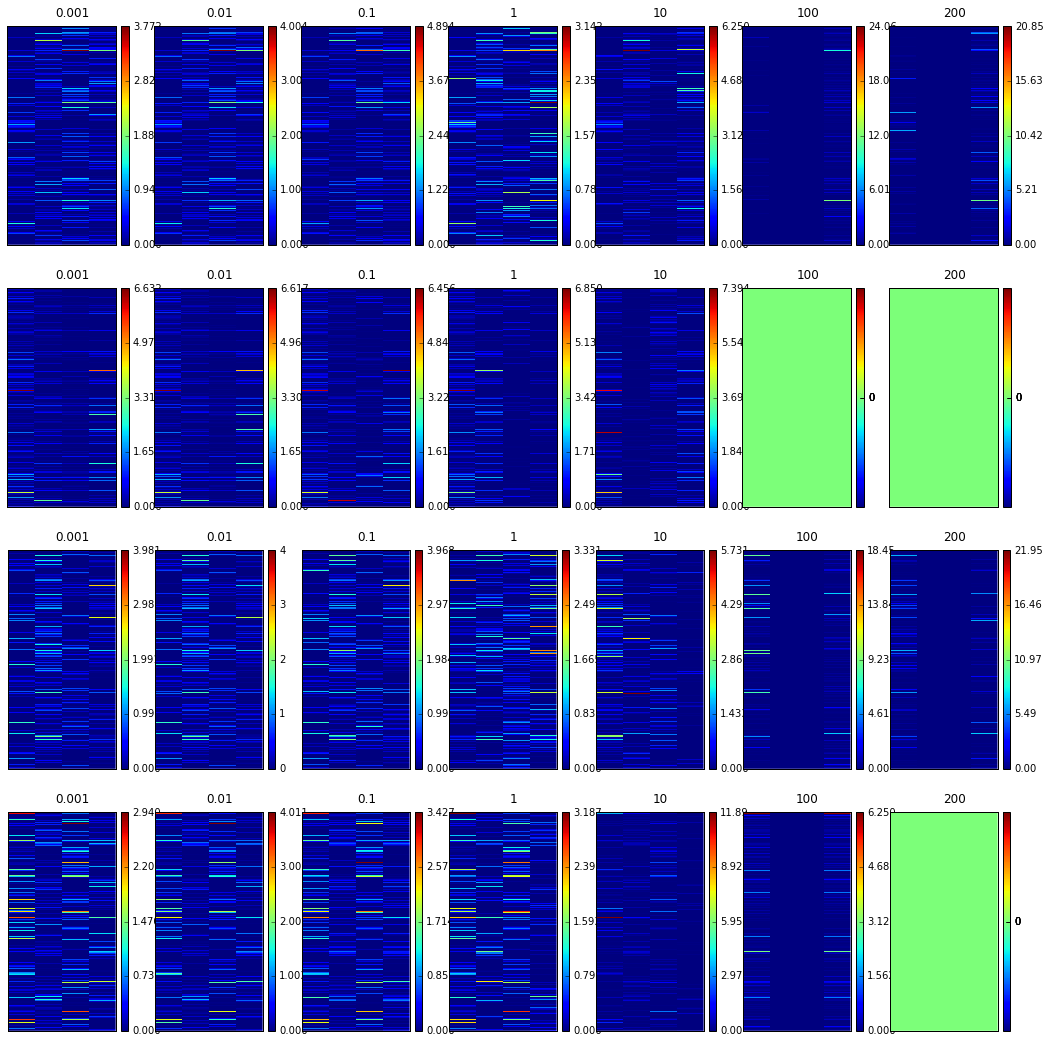

In [95]:
plt.figure(figsize=(15,6))
plt.subplot(121)
for pen in pens:
    plt.plot(np.log(0.000001 + np.array(sparsity_coefs)), np.array(pen))
plt.subplot(122)
for Fs in Fss:
    plt.plot(np.log(0.000001 + np.array(sparsity_coefs)), np.array([np.sum(np.abs(F[0])) for F in Fs]))

plt.figure(figsize=(18,18))
for i, Fs in enumerate(Fss):
    for j, F in enumerate(Fs):
        plt.subplot(len(ego_paths), len(sparsity_coefs), j+i*len(Fs)+1)
        draw_matrix(F[0], sparsity_coefs[j])

Видна похожая тенденция при больших значениях штрафа -- в матрице F зануляется часть сообществ, возможно, это можно использовать для поддобра количества сообществ в графе, не ясно как подбирать величину штрафа.

Отделим значение F от нуля значением 0.01 и проведем такой же эксперимент для модельных данных

# 7. Зависимость качества оптимизации от параметра alpha

Параметр из процедуры подбора шага *backtrakingLineSearch*.

Будем проверять на самом простом примере с 2 сообществами и на реальных данных

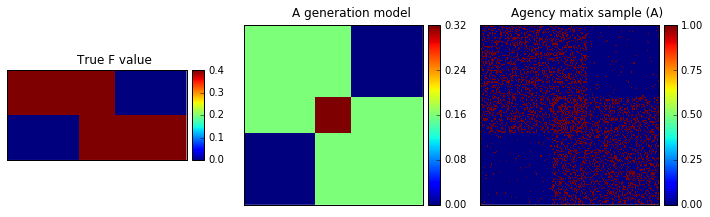

In [18]:
test_size = 8
F_true_bc = 0.4 * np.array([[1] * 12 * test_size + [0] * 8 * test_size, [0] * 8 * test_size + [1] * 12 * test_size])
B_bc = big_clam_model_test_data(F_true_bc)
draw_test_sample(F_true_bc, B_bc)

In [45]:
K = 2
init = None

Fs = []
itersLLH = []
alphas = [0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
for alpha in log_progress(alphas):
    bigClam = BigClam(B_bc, K, initF='rand' if init is None else init, debug_output=False, LLH_output=False, eps=1e-2, alpha=alpha, iter_output=1)
    res = bigClam.fit()
    Fs.append(res[0])
    itersLLH.append(bigClam.LLH_output_vals)
    if init is None:
        init = bigClam.initFmode.copy()

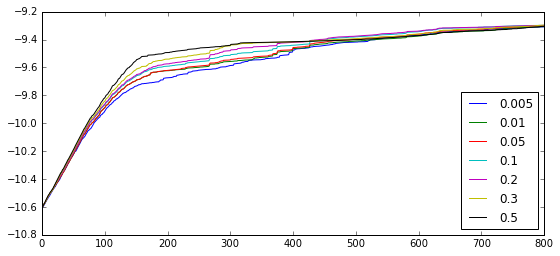

In [47]:
plt.figure(figsize=(9,4))
for llh, alpha in zip(itersLLH, alphas):
    plt.plot(-np.log(-np.array(llh[:800])), label=str(alpha))
plt.legend(loc=4)

На маленьком тестовом примере значение alpha почти ни на что не влияет.

Посмотрим на реальных данных.

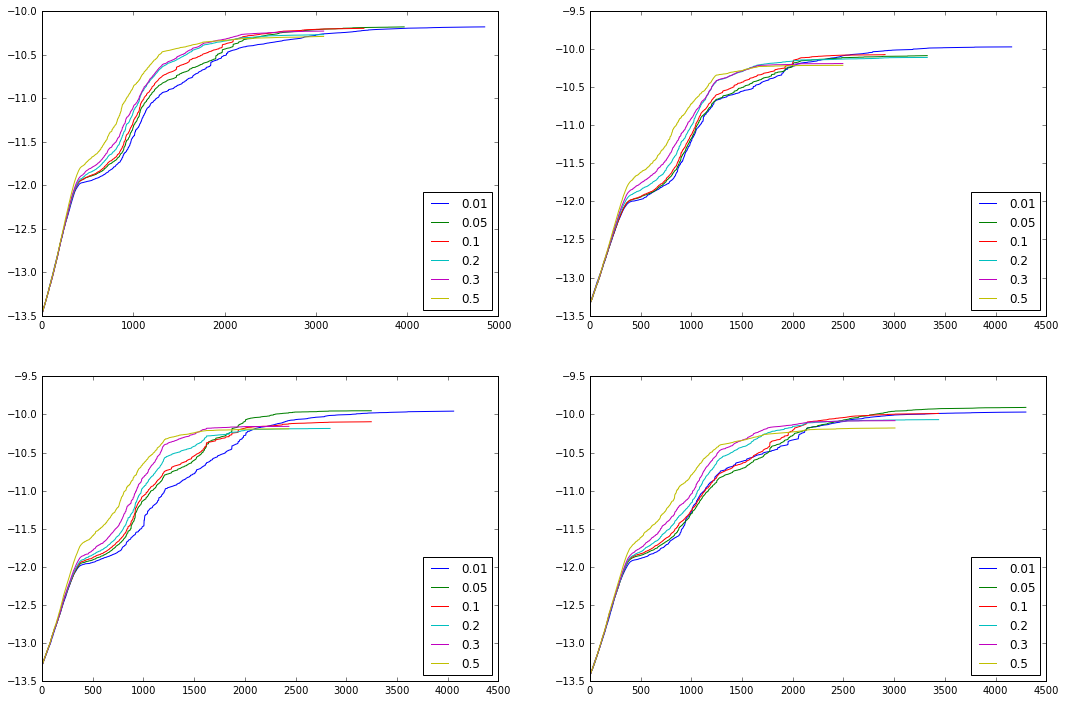

In [96]:
K = 4
import os
DATA_PATH = '../data/vk/'
ego_paths = [f for f in os.listdir(DATA_PATH) if f.endswith(".ego")]

alphas = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
plt.figure(figsize=(18,12))
for indx, ego in enumerate(ego_paths):
    D = cPickle.load(file('../data/vk/{}'.format(ego)))
    G = nx.Graph(D)
    A = np.array(nx.to_numpy_matrix(G))
    init = None
    Fs = []
    itersLLH = []
    for alpha in log_progress(alphas):
        bigClam = BigClam(A, K, initF='rand' if init is None else init, debug_output=False, LLH_output=False, eps=1e-2, alpha=alpha, iter_output=1)
        res = bigClam.fit()
        Fs.append(res[0])
        itersLLH.append(bigClam.LLH_output_vals)
        if init is None:
            init = bigClam.initFmode.copy()
    plt.subplot(2,2,indx+1)
    for llh, alpha in zip(itersLLH, alphas):
        plt.plot(-np.log(-np.array(llh)), label=str(alpha))
    plt.legend(loc=4)